# First-break picking with Hidden Markov Model

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Problem description

Each seismic trace has a time lag before a seismic wave, originated at the shot point, arrives the receiver. This time lag should be specified to enable trace alingment and velocity estimation.

## Dataset

We exploit traces from Dataset 1 for trainig and testing. Detailed description of the dataset is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

Required imports:

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import dill
import matplotlib.pyplot as plt
from functools import partial
from hmmlearn import hmm

sys.path.append('../../..')

from seismicpro.batchflow import Dataset, Pipeline, B, V, F

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex,
                            merge_picking_files, seismic_plot)
from seismicpro.models import HMModel, make_hmm_data
from seismicpro.src.metrics import PickingMetrics

Index dataset:

In [2]:
path_raw = '/data/FB/dataset_1/Pal_Flatiron_1k.sgy'
markup_path='/data/FB/dataset_1/Pal_Flatiron_1k_picking.csv'

index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
         
index.head()

,TraceNumber,FIRST_BREAK_TIME,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
10407,1956,77.291588,1,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1957,75.197472,2,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1955,95.463326,3,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1958,96.654495,4,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1954,114.333763,5,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy


Load sample seismogram and labeled picking times:

In [3]:
batch = (Dataset(index, SeismicBatch).next_batch(batch_size=1)
        .load
         (components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

Show the seismogram and labeled picking times:

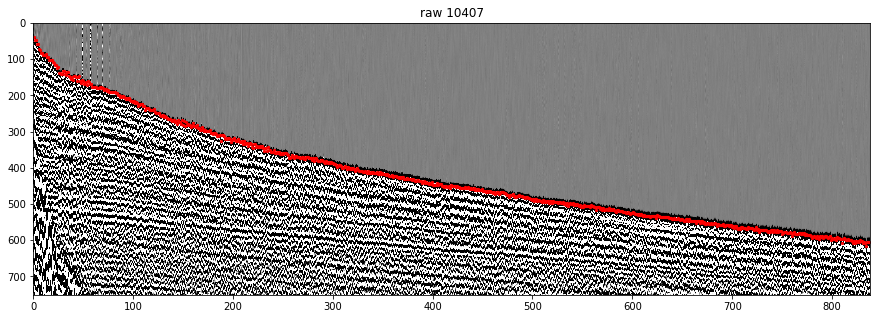

In [4]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, scatter_color='r'))

Sample traces in a wiggle plot:

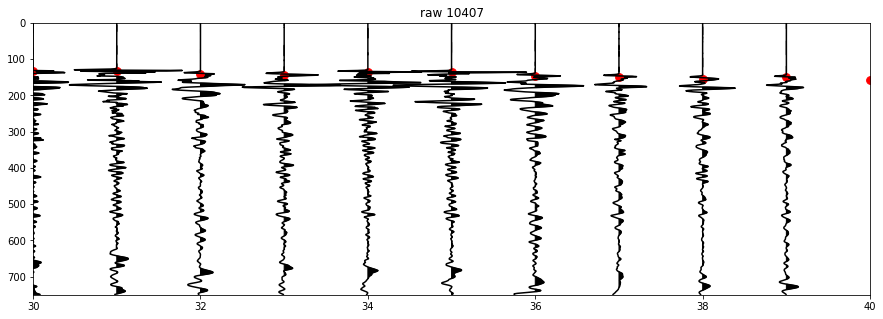

In [5]:
batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=60, scatter_color='r',
                    wiggle=True, xlim=(30,40), ylim=(0,750), std=0.1)

Define a train dataset. It constsis of the first field record only:

In [6]:
train_index = index.create_subset(index.indices[:1])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)

Train set includes 101 field records:

In [7]:
test_set = Dataset(TraceIndex(index.create_subset(index.indices[900:])), SeismicBatch)

## Model architecture

We exploit a Hidden Markov Model with 2 hidden states. It is supposed that one state corresponds to signal, while the second one corresponds to noise (no-signal). The first change from noise state to signal state is assosiated with seismic wave arrival (first-break moment). It is also supposed that at  each trace is more likely to start at noise state.

Model config:

In [8]:
config_train = {
    'build': True,
    'estimator': hmm.GaussianHMM(n_components=2, n_iter=20, covariance_type="full")
}

## Training

Model training pipeline:

In [9]:
batch_size = 1

train_pipeline = (Pipeline()
                 .init_model('dynamic', HMModel, 'HMM', config=config_train)
                 .init_variable('predictions', init_on_each_run=list())
                 .load(components='raw', fmt='segy')
                 .normalize_traces(src='raw', dst='raw')
                 .gradient(src='raw', dst='raw')
                 .cwt(src='raw', dst='raw', scales=[4], wavelet='mexh')
                 .train_model('HMM', make_data=partial(make_hmm_data, components='raw'))
                 .run(batch_size=batch_size, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=True))

Run the training pipeline:

In [10]:
(train_set >> train_pipeline).run()

100%|█████████▉| 837/838 [02:22<00:00,  6.51it/s]


Dump the trained model:

In [11]:
train_pipeline.save_model_now("HMM", path="hmm_picks_model.dill")

The desired picking should correspond to the first amplitude maximum. Below we estimate a time shift between HMM model output and target picking. Define a pipeline to obtain model output and targets:

In [12]:
hmmodel_path = "hmm_picks_model.dill"

config_predict = {
    'build': False,
    'load': {'path': hmmodel_path}
}

estimation_ppl = (Pipeline()
                  .init_model('static', HMModel, 'HMM', config=config_predict)
                  .init_variable('picking', init_on_each_run=list())
                  .init_variable('predictions', init_on_each_run=list())
                  .load(components='raw', fmt='segy')
                  .load(components='markup', fmt='picks')
                  .normalize_traces(src='raw', dst='raw')
                  .picking_to_mask(src='markup', dst='markup')
                  .update_variable('picking', B('markup'), mode='a')
                  .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                  .gradient(src='raw', dst='grad')
                  .cwt(src='grad', dst='wavelet', scales=[4], wavelet='mexh')
                  .predict_model('HMM', make_data=partial(make_hmm_data, components='wavelet'),
                                 save_to=V('predictions', mode='a'))
                  .run(batch_size=100, shuffle=False, drop_last=False, n_epochs=1, lazy=True, bar=True)
                 )

Run the pipeline

In [13]:
estimation_ppl = (train_set >> estimation_ppl).run()

 89%|████████▉ | 8/9 [00:03<00:00,  1.99it/s]


Arrange predicted and target arrays:

In [14]:
pred = np.vstack([i[0] for i in np.hstack(estimation_ppl.get_variable('predictions'))])
true = np.vstack(np.hstack(estimation_ppl.get_variable('picking')))

Derive a picking time as a first change from 0 to 1 state:

In [15]:
true = np.argmax(true, axis=1)
pred = np.argmax(pred, axis=1)

Shift estimation:

In [16]:
shift_value = np.rint(np.median(pred - true)).astype(int)
print("Estimated shift:", shift_value)

Estimated shift: -22


## Model evaluation

Test pipeline:

In [18]:
batch_size = 100
cv = 1000

test_pipeline = (Pipeline()
                 .init_model('static', HMModel, 'HMM', config=config_predict)
                 .init_variable('picking', init_on_each_run=list())
                 .init_variable('traces', init_on_each_run=list())
                 .init_variable('predictions', init_on_each_run=list())
                 .load(components='raw', fmt='segy')
                 .load(components='markup', fmt='picks')
                 .normalize_traces(src='raw', dst='raw')
                 .picking_to_mask(src='markup', dst='markup')
                 .update_variable('traces', B('raw'), mode='a')
                 .update_variable('picking', B('markup'), mode='a')
                 .clip(a_min=-cv, a_max=cv, src='raw', dst='raw')
                 .gradient(src='raw', dst='grad')
                 .cwt(src='grad', dst='wavelet', scales=[4], wavelet='mexh')
                 .predict_model('HMM', make_data=partial(make_hmm_data, components='wavelet'),
                                save_to=V('predictions', mode='a'))
                 .run(batch_size=batch_size, shuffle=False, drop_last=False, n_epochs=1, lazy=True, bar=True)
                )

Run pipeline on a test subset (101 field records):

In [19]:
test_set = Dataset(TraceIndex(index.create_subset(index.indices[900:])), SeismicBatch)
test_pipeline = (test_set >> test_pipeline).run()

100%|█████████▉| 831/832 [07:28<00:00,  1.77it/s]


Show test seismograms and first-break picks:

Arrange arrays:

In [20]:
pred = np.vstack([i[0] for i in np.hstack(test_pipeline.get_variable('predictions'))])
true = np.vstack(np.hstack(test_pipeline.get_variable('picking')))
raw = np.vstack(np.hstack(test_pipeline.get_variable('traces')))

Derive a picking time as a first change from 0 to 1 state:

In [21]:
true = np.argmax(true, axis=1) + shift_value
pred = np.argmax(pred, axis=1)

Plot sample traces with predicted and target picking:

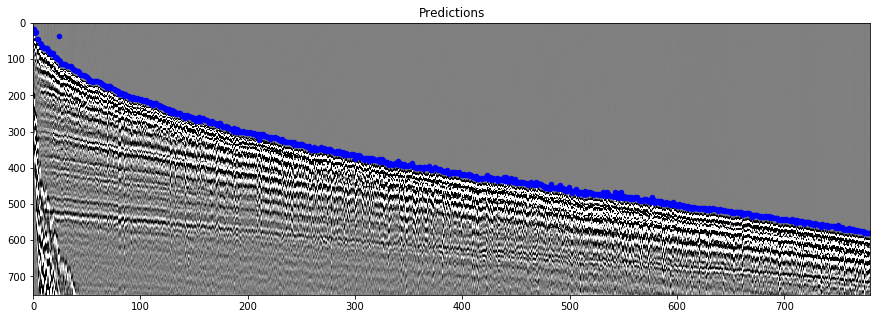

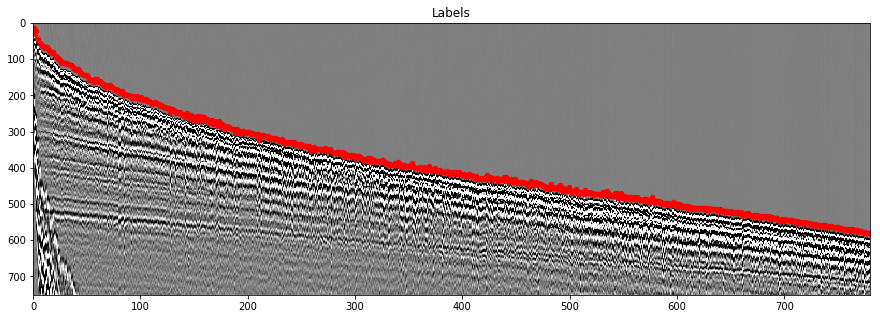

In [22]:
x = range(780)
cv = 1
pts = (x, pred[x])
seismic_plot(raw[x], cmap='gray',vmax=cv, vmin=-cv, pts=pts,
             s=20, scatter_color='b', figsize=(15, 5), names=['Predictions'])

pts = (x, true[x])
seismic_plot(raw[x], cmap='gray',vmax=cv, vmin=-cv, pts=pts,
             s=20, scatter_color='r', figsize=(15, 5), names=['Labels'])

Compute metrices in the test dataset:

In [23]:
metrics = PickingMetrics(true, pred, gap=3)

In [24]:
print('MAE on dataset 1 validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on dataset 1 validation: 2.610


In [25]:
print('Accuracy on dataset 1 validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on dataset 1 validation: 81.17%


## Criticism

There is a number of ouliers in picking times and post-processing is required to achieve a desired picking, e.g. at the first amplitude maximum.

## Conclusion

While the model separates trace into two parts, it is rather unrealistic to achive a precise picking, e.g. at the first amplitude maximum, with HMM model without substantial post-processing.

## Suggestions for improvements

At the moment we are looking for a first state change to get picking time. A more sophisticated approach might reduce the number of outliers and provide a more accurate picking. 